# Départements contours & population

## Download departements contours

In [1]:
import requests
import os

current_dir = os.path.abspath("")

departement_contours_filename = "departements-20140306-50m-shp.zip"
# 5m precision also available but produces havier maps
# departement_contours_filename = "departements-20140306-5m-shp.zip
url = "http://osm13.openstreetmap.fr/~cquest/openfla/export/" + departement_contours_filename

response = requests.get(url)
assert response.status_code == 200

local_filename = os.path.join(current_dir, url.split('/')[-1])
with open(local_filename, 'wb') as output_file:
    output_file.write(response.content)

## Download departements population & contours

In [19]:
import requests

url = "https://www.insee.fr/fr/statistiques/fichier/6683035/ensemble.zip"

response = requests.get(url, verify=False)
assert response.status_code == 200

with open(
    os.path.join(current_dir, 'ensemble.zip'),
    'wb') as output_file:
    output_file.write(response.content)

from zipfile import ZipFile

unzip = ZipFile(os.path.join(current_dir, 'ensemble.zip'))
unzip.extractall(os.path.join(current_dir, 'fr_population'))

C:\Users\Antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'www.insee.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings



In [3]:
from zipfile import ZipFile

unzip = ZipFile(local_filename)

extraction_dir = os.path.join(
    current_dir,
    departement_contours_filename.replace(".zip", "")
)
unzip.extractall(
    extraction_dir
)
# unzip.filelist

In [4]:
import geopandas as gpd

departements_df = gpd.read_file(
    os.path.join(
        extraction_dir,
        # "departements-20140306-5m.shp",
        "departements-20140306-50m.shp",
    )
)
code_to_geom = departements_df[['code_insee', 'geometry']].set_index('code_insee').geometry.to_dict()


## Translate departement code to name and population

In [20]:
import pandas as pd
from random import shuffle
population = pd.read_csv(
    os.path.join(
        current_dir,
        'fr_population/donnees_departements.csv'
    ), sep=';')

code_to_population = population[['CODDEP', 'PTOT']].set_index('CODDEP').PTOT.to_dict()
code_to_name = population[['CODDEP', 'DEP']].set_index('CODDEP').DEP.to_dict()

departements_codes_sample = population['CODDEP'].sample(5)
for code in departements_codes_sample:
    print("Name:", code_to_name[code], f"Population: {code_to_population[code]:,}")

Name: Eure Population: 612,766
Name: La Réunion Population: 872,635
Name: Pas-de-Calais Population: 1,483,731
Name: Dordogne Population: 423,298
Name: Vaucluse Population: 572,909


# Sport memberships in France

## Download data

In [6]:
import requests 

url = (
    "https://static.data.gouv.fr/resources/"
    "donnees-geocodees-issues-du-recensement-des-licences-et-clubs-aupres-des-federations-sportives-agreees-par-le-ministere-charge-des-sports/"
    "20231207-134903/lic-data-2021.csv"
)

sport_memberships_filename = os.path.join(
    current_dir,
    url.split("/")[-1]
)

response = requests.get(url)
assert response.status_code == 200

with open(sport_memberships_filename, 'wb') as output_file:
    output_file.write(response.content)


In [7]:
import pandas as pd
sport_memberships_df = pd.read_csv(sport_memberships_filename, sep=';')
sport_memberships_by_department = sport_memberships_df.groupby(['Fédération', 'Département'], as_index=False).agg(
    {"Total": "sum"}
)
sport_memberships_by_department['code_insee'] = sport_memberships_by_department.Département.apply(
    lambda x: f'{x:02}' if isinstance(x, int) else x
)

C:\Users\Antoine\AppData\Local\Temp\ipykernel_40896\3873248241.py:2: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  sport_memberships_df = pd.read_csv(sport_memberships_filename, sep=';')


## Aggregate with departments infos (name, contour, population)

In [8]:
sport_memberships_by_department['geometry'] = sport_memberships_by_department.code_insee.map(code_to_geom)
sport_memberships_by_department['name'] = sport_memberships_by_department.code_insee.map(code_to_name)
sport_memberships_by_department['population'] = sport_memberships_by_department.code_insee.map(code_to_population)

## Filter by sport federation & compute share of memberships by department's population

In [9]:
# Top sport federations
federation_subsets = [["FF de Football"],
["FF de Tennis"],
["FF d'Équitation"],
["FF de Golf"],
["FF de Basketball"],
["FF de Judo, Jujitsu, Kendo et DA"],
["FF de Handball"],
["FF de Rugby"],
["FF de Natation"],
["FF d'Éducation Physique et de Gymnastique Volontaire"],
["FF de Voile"],
["FF d'Athlétisme"],
["FF de Gymnastique"],
["FF de Tir"],
["FF de Pétanque et Jeu Provençal"],
["FF de la Randonnée Pédestre"],
["FF de Karaté et DA"],
["FF de Badminton"],
["FF de Tennis de Table"],
["FF de Volley"],
["FF d'Études et Sports Sous-Marins"],
["FF de Cyclisme"],
["FF Sports Pour Tous"],
["FF de la Montagne et de l'Escalade"],
["FF des Clubs Alpins et de Montagne"],
["FF de Ski"],
["FF de la Retraite Sportive"],
["FF de Motocyclisme"],
["FF de Tir à l'Arc"],
["FF de Danse"],
["FF de Triathlon et Disciplines Enchainées"],
["FF de Roller et Skateboard"],
["FF d'Escrime"],
["FF d'Aviron"],
["Union Nationale des Clubs Universitaires"],
["FF Aéronautique"],
["FF de Canoë-Kayak et Sports de Pagaie"],
["FF du Sport Automobile"],
["FF des Échecs"],
["F Nationale du Sport en Milieu Rural"],]

df_by_federation = {}
for federation_subset in federation_subsets:
    if federation_subset is not None:
        filt_sport_memberships = sport_memberships_by_department[sport_memberships_by_department.Fédération.apply(lambda x: x in federation_subset)]
    
    filt_sport_memberships = filt_sport_memberships.groupby('code_insee', as_index=False).agg(
        {'Total': 'sum', 'population': 'sum', 'geometry': 'first', 'name': 'first', }
    )
    # Remove lines where population is 0 or unknown to avoid wrong values in proportion
    filt_sport_memberships = filt_sport_memberships[filt_sport_memberships.population!=0]
    filt_sport_memberships['share'] = filt_sport_memberships.Total/filt_sport_memberships.population
    
    df_by_federation[", ".join(federation_subset)] = filt_sport_memberships

print(", ".join(federation_subset))
filt_sport_memberships.sample(5)

F Nationale du Sport en Milieu Rural


code_insee  Total  population  \
18         19    165    246927.0   
35         36    109    224356.0   
39         40    292    430346.0   
30         31   1033   1439027.0   
8          09     10    157899.0   

                                             geometry           name     share  
18  POLYGON ((2.364446586346622 45.37486667181372,...        Corrèze  0.000668  
35  POLYGON ((2.0887238015829084 46.4103024124311,...          Indre  0.000486  
39  POLYGON ((-0.3009935615158653 43.5714778921177...         Landes  0.000679  
30  POLYGON ((1.493073394565357 43.237256216292664...  Haute-Garonne  0.000718  
8   POLYGON ((1.90727345666972 42.767339105473, 1....         Ariège  0.000063

## Visualize the share of memberships by department's population

In [11]:
import folium
import branca.colormap as cmp
from plotly.colors import sequential, diverging
from ast import literal_eval
from tqdm import tqdm
import os

progress_bar = tqdm(df_by_federation.items())

for federation_name, federation_df in progress_bar:
    progress_bar.set_description_str(federation_name)
    
    m = folium.Map(location=(47, 2.34), height=800, width=800, zoom_start=6)
    
    colors = [literal_eval(x.replace('rgb', '')) for x in diverging.Portland_r]
    colormap = cmp.LinearColormap(
        colors=colors,
        vmin=0,
        vmax=federation_df.share.max()
    )
    
    colormap.add_to(m)
    
    for proportion, geom, name in zip(
        federation_df.share, 
        federation_df.geometry,
        federation_df.name,
    ):
        if geom is None: continue
        folium.GeoJson(
            geom,
            weight=1,
            color=colormap(proportion),
            opacity=0.8,
            fill_color=colormap(proportion),
            fill_opacity=0.8,
            zoom_on_click=True,
            tooltip=f'{name}: {proportion*100:.3f}%'
        ).add_to(m)

    map_name = "proportion_licencies_par_departements"
    map_name += f'_{federation_name.replace(" ", "_")}'
    map_name += ".html"

    current_dir = os.path.abspath('.')
    m.save(os.path.join(current_dir, "maps", map_name))
    png_map_name = os.path.join(
        current_dir,
        f'map_images/{federation_name.replace(" ", "_")}.png'
    )
    
    with open(
        png_map_name, 'wb'
    ) as outfile:
        outfile.write(m._to_png(1))
m

F Nationale du Sport en Milieu Rural: 100%|████████████████████████████████████████████| 40/40 [17:16<00:00, 25.91s/it]


C:\Users\Antoine\AppData\Local\Temp\ipykernel_40896\710089468.py:41: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



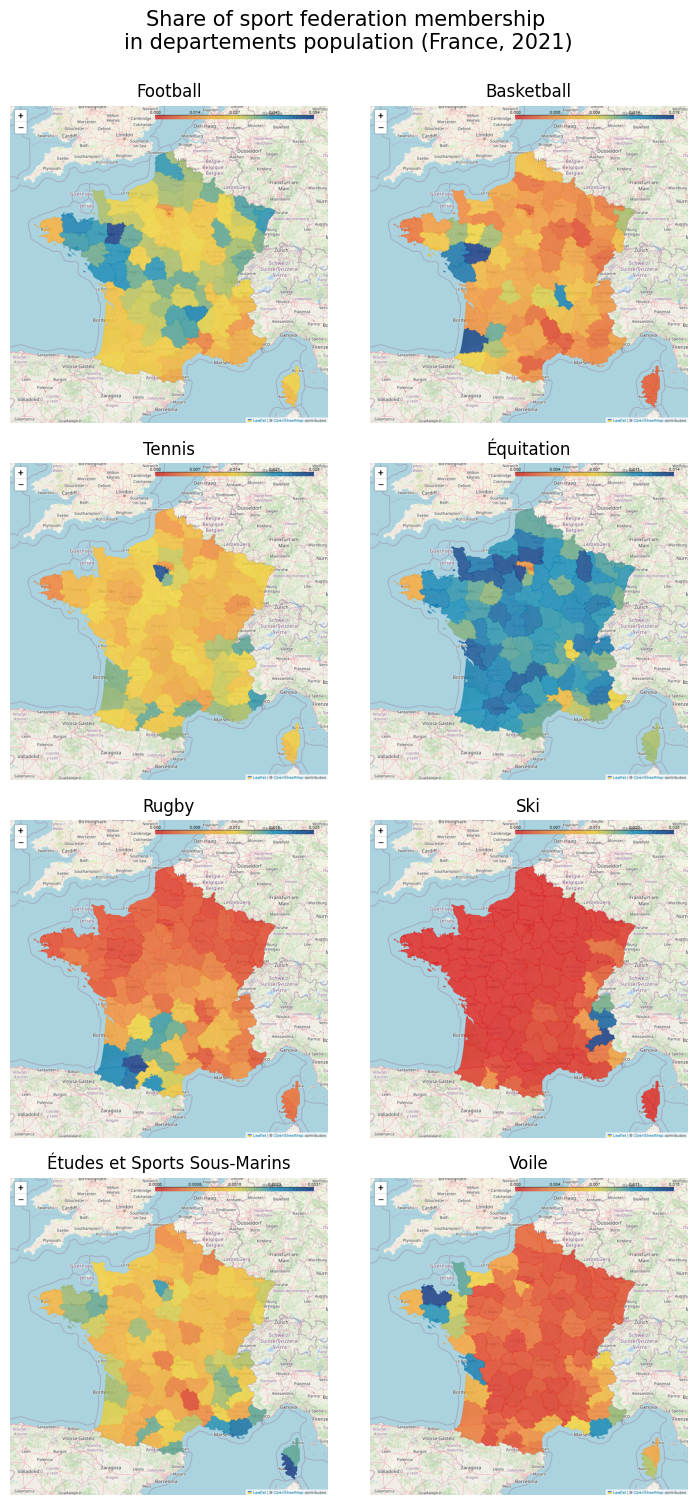

In [42]:
from PIL import Image
import plotly.express as px

map_images_dir = os.path.join(current_dir,'map_images')

images_to_display = [
    ['FF_de_Football.png', 'FF_de_Basketball.png'],
    ['FF_de_Tennis.png', 'FF_d\'Équitation.png'],
    ['FF_de_Rugby.png', 'FF_de_Ski.png'],
    ['FF_d\'Études_et_Sports_Sous-Marins.png', 'FF_de_Voile.png'],
]
titles_to_display = [
    ['Football', 'Basketball'],
    ['Tennis', 'Équitation'],
    ['Rugby', 'Ski'],
    ['Études et Sports Sous-Marins', 'Voile']
]

import matplotlib.pyplot as plt

n_rows = len(images_to_display)
n_cols = max(len(line) for line in images_to_display)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 15))


for i in range(len(images_to_display)):
    for j in range(len(images_to_display[i])):
        img = Image.open(os.path.join(map_images_dir, images_to_display[i][j]))
        ax[i,j].imshow(img)
        ax[i,j].axis('off')
        ax[i,j].set_title(titles_to_display[i][j], fontsize=12)   

fig.suptitle(
    'Share of sport federation membership \nin departements population (France, 2021)',
    fontsize=15,
    y=1
)
fig.set_tight_layout(2)
fig.savefig('outputs/fr_sport_memberships_sample.png')
fig.show()
